# Replica project

### The data

In [3]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import Image as Image2
import numpy as np

from torch import nn
import torchvision.models as models
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from urllib.request import urlretrieve 
import pickle
from glob import glob
from scipy import sparse

from torch.utils.data import DataLoader

from utils import *
from dataloader_replica import ReplicaDataset
from train_replica import train_replica
from model_replica import ReplicaNet

import umap

from utils import * 
path = '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/data/'
data_dir = '/scratch/students/schaerf/'



2022-03-21 15:47:48.366164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
data = pd.read_csv(data_dir + 'full_data.csv').drop(columns=['Unnamed: 0', 'level_0'])
print(data.shape)
data.head()

(6163, 45)


,uid_connection,index,uid,Drawer,ImageNumber,Author,Description,AuthorOriginal,AuthorULANLabel,AuthorULAN,...,AuthorBirthCity,AuthorDeathCity,CardboardURL,ImageURL,img1,img2,type,annotated,cluster,set
0,002ca9c06a704c779e69d93cb4fadaa3,649,45588b4e33444ed8b34c523bac808bc4,158B,556,TIZIANO Vecellio (copia da),S.Mariá Maddalena. cm. 123 x 91,TIZIANO (copia da -),Titian,ulan:500031075,...,Belluno,Venice,https://dhlabsrv4.epfl.ch/iiif_cini/158B%2F158...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,45588b4e33444ed8b34c523bac808bc4,da54c106180449d1a52993e9a5bc17fd,POSITIVE,2018-07-24 14:58:44.559049+00:00,50.0,train
1,0038ab462149452b98a4d7359a06f9f4,1571,ae828b07e4284d80b652206ffb77278a,158C,120,TIZIANO Vecellio (copia da),"Morte di S. Pietro Martire. mm. 123,8 x 84,2",TIZIANO (copia da -),Titian,ulan:500031075,...,Belluno,Venice,https://dhlabsrv4.epfl.ch/iiif_cini/158C%2F158...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,ae828b07e4284d80b652206ffb77278a,ea64207684694d379579998f88b7c29a,POSITIVE,2018-07-16 09:47:57.987515+00:00,51.0,test
2,00474897de044f7fb1ef16888dc198f3,1107,76b2c4aeab404bc79768117e3ddc62b1,47A,858,BELLINI Giovanni (cerchia di),Pietà.,"BELLINI, Giovanni (cerchia di -)","Bellini, Giovanni",ulan:500019244,...,Venice,Venice,https://dhlabsrv4.epfl.ch/iiif_cini/47A%2F47A_...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,76b2c4aeab404bc79768117e3ddc62b1,b8dd2c0c2c7146e68e5bbb0aaf6cf803,POSITIVE,2018-03-14 10:46:45.603341+00:00,498.0,test
3,009c03c265b8418495da038bc3826bf7,1764,c5839e5220e5419e92d878396b0c04bb,135C,57,SEC XVI ex,Un soffitto. Part.: Leda e il cigno.,SEC. XVI ex.,NaN,NaN,...,NaN,NaN,https://dhlabsrv4.epfl.ch/iiif_cini/135C%2F135...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,450ee2aceb014709b23a93e1163937c5,c5839e5220e5419e92d878396b0c04bb,POSITIVE,2018-05-07 08:28:11.797723+00:00,92.0,train
4,00aeddb93a8a4120aa984eda6c822747,747,4d02860f58f2443ba4d1ef088756f854,21C,228,BASSANO Leandro,"La preparazione del pranzo. cm. 88,3 x 102,9","BASSANO, Leandro.","Bassano, Leandro",ulan:500015945,...,Bassano del Grappa,Venice,https://dhlabsrv4.epfl.ch/iiif_cini/21C%2F21C_...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,4d02860f58f2443ba4d1ef088756f854,27bad0f213a342c3987e8cec61e40550,POSITIVE,2018-03-23 15:41:53.094226+00:00,218.0,train


### Creating embeddings of all the images

In [22]:
def create_model(model_name, pooling):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
    elif model_name == "efficientnet0":
        model = models.efficientnet_b0(pretrained=True)
    elif model_name == "efficientnet7":
        model = models.efficientnet_b7(pretrained=True)

    if pooling == "avg":
        newmodel = torch.nn.Sequential(
            *(list(model.children())[:-2]), nn.AdaptiveAvgPool2d((1, 1))
        )
    elif pooling == 'max':
        newmodel = torch.nn.Sequential(
            *(list(model.children())[:-2]), nn.AdaptiveMaxPool2d((1, 1), )
        )
    
    return newmodel

def preprocess_image_orig(img_name, resolution=480):
    img = Image.open(img_name)
    tfms = transforms.Compose(
        [
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    return tfms(img).unsqueeze(0)


def get_embedding_orig(img, model, device='cpu'):
    embedding = model(img.squeeze(1).to(device))[0].cpu().detach().numpy()
    norm = np.linalg.norm(embedding)
    return embedding / norm


# print(model)


In [26]:
img = preprocess_image_orig(data_dir + 'subset/' + data['uid'][0] + '.jpg')
newmodel = create_model('resnet50', 'max')
embedding = get_embedding_orig(img, newmodel).squeeze(1).squeeze(1)
print(embedding.shape)
embedding

(2048,)


array([0.01368189, 0.02313367, 0.01797748, ..., 0.02025607, 0.01675818,
       0.01065022], dtype=float32)

In [27]:
newmodel = create_model('resnet50', 'max')
embeddings = [[uid, get_embedding_orig(preprocess_image_orig(data_dir + 'subset/' + uid + '.jpg'), newmodel).squeeze(1).squeeze(1)] for uid in tqdm(data['uid'].unique())]

100%|██████████| 4357/4357 [23:13<00:00,  3.13it/s]


In [ ]:
np.save('resnet50_max_480.npy', np.array(embeddings, dtype=np.ndarray))

In [7]:
embeddings = np.load('resnet50_max_480.npy', allow_pickle=True)
embeddings

array([['45588b4e33444ed8b34c523bac808bc4',
        array([0.01368189, 0.02313367, 0.01797748, ..., 0.02025607, 0.01675818,
       0.01065022], dtype=float32)],
       ['ae828b07e4284d80b652206ffb77278a',
        array([0.02267348, 0.02207473, 0.02679155, ..., 0.01316007, 0.01706073,
       0.0239618 ], dtype=float32)],
       ['76b2c4aeab404bc79768117e3ddc62b1',
        array([0.01994276, 0.02536203, 0.02381043, ..., 0.0210929 , 0.02055986,
       0.01366972], dtype=float32)],
       ...,
       ['ffd362f3b0f64665a6d4708b62c6333c',
        array([0.02442177, 0.01836587, 0.01773359, ..., 0.01279425, 0.02543648,
       0.01438388], dtype=float32)],
       ['ffd9ce3649364906810269748b8a5ddc',
        array([0.01238512, 0.01889924, 0.01867861, ..., 0.01401675, 0.02105789,
       0.01638981], dtype=float32)],
       ['fffb47ce9194475087f2c7dc1eaaa41a',
        array([0.01438884, 0.0334691 , 0.01874444, ..., 0.01686426, 0.02170148,
       0.01797038], dtype=float32)]], dtype=object)

### Finding most similar embeddings

In [92]:
def make_tree_orig(embeds):
    kdt = BallTree(np.vstack(embeds[:,1]), metric="euclidean")
    return kdt

def find_most_similar_orig(uid, tree, embeds, uids, n=401):
    img = np.vstack(embeds[embeds[:,0] == uid][:,1]).reshape(1, -1)
    cv = tree.query(img, k=n)[1][0]
    return [uids[c] for c in cv if uids[c] != uid] #not in uids_match

def find_pos_matches(uids_sim, uids_match, how='all'):
    matched = list(filter(lambda i: uids_sim[i] in uids_match, range(len(uids_sim))))
    while len(matched) < len(uids_match):
        matched.append(400)
    if how == 'all':
        if len(matched) > 0:
            return matched
        else:
            return [400]
    elif how == 'first':
        if len(matched) > 0:
            return matched[0]
        else:
            return 400
    elif how == 'median':
        if len(matched) > 0:
            return np.median(np.array(matched))
        else:
            return 400

def make_rank(uids_sim, uids_match):
    return [1 if uid in uids_match else 0 for uid in uids_sim]
        

In [81]:
np.vstack(embeddings[:,1])

array([[0.01368189, 0.02313367, 0.01797748, ..., 0.02025607, 0.01675818,
        0.01065022],
       [0.02267348, 0.02207473, 0.02679155, ..., 0.01316007, 0.01706073,
        0.0239618 ],
       [0.01994276, 0.02536203, 0.02381043, ..., 0.0210929 , 0.02055986,
        0.01366972],
       ...,
       [0.02442177, 0.01836587, 0.01773359, ..., 0.01279425, 0.02543648,
        0.01438388],
       [0.01238512, 0.01889924, 0.01867861, ..., 0.01401675, 0.02105789,
        0.01638981],
       [0.01438884, 0.0334691 , 0.01874444, ..., 0.01686426, 0.02170148,
        0.01797038]], dtype=float32)

In [82]:
tree = make_tree_orig(embeddings)

In [ ]:
list_downloaded = [file.split('/')[-1].split('.')[0] for file in glob(data_dir + 'subset/*')]
list_downloaded[0]

In [98]:
train_test = data[data['set'].notnull()].reset_index()

Cs = []
Bs = []
pos = []
ranks = []

for i in tqdm(range(train_test.shape[0])):
    if train_test['uid'][i] in list_downloaded:
        list_theo = list(train_test[train_test['img1'] == train_test['uid'][i]]['img2']) + list(train_test[train_test['img2'] == train_test['uid'][i]]['img1']) + [train_test['uid'][i]]
        Bs.append(list_theo)
        list_ = find_most_similar_orig(train_test['uid'][i], tree, embeddings, list(data['uid'].unique()), n=4357)
        Cs.append(list_[:400])
        matches = find_pos_matches(list_[:400], list_theo, how='all')
        pos.append(matches)
        rank = make_rank(list_, list_theo)
        ranks.append(rank)
len(Cs)


100%|██████████| 2862/2862 [00:49<00:00, 57.62it/s]


2862

Text(0.5, 0, 'Data')

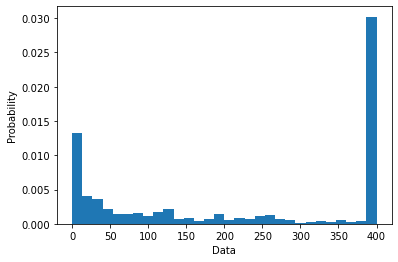

In [99]:
posses = [po for p in pos for po in p]
posses_min = [p[0] for p in pos]
posses_med = [np.median(np.array(p)) for p in pos]
posses


plt.hist(posses_min, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [100]:
print('all', np.mean(np.array(posses)), np.median(np.array(posses)))
print('min', np.mean(np.array(posses_min)), np.median(np.array(posses_min)))
print('median', np.mean(np.array(posses_med)), np.median(np.array(posses_med)))

all 355.20255693168195 400.0
min 217.79350104821802 219.0
median 389.54542278127184 400.0


In [122]:
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item

    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).

    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    """Score is precision after all relevant documents have been retrieved

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k


    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Precision @ k

    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def recall_at_k(r, k):
    """Score is precision @ k

    """
    assert k >= 1
    true = np.asarray(r)[np.asarray(r) != 0]
    r = np.asarray(r)[:k][np.asarray(r)[:k] != 0]
    if len(true) > 0:
        return len(r) / len(true)
    else:
        return 0

def average_precision(r):
    """Score is average precision (area under PR curve)

    Relevance is binary (nonzero is relevant).

    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
    >>> average_precision(r)
    0.78333333333333333
    >>> average_precision([1,1,0,0]) == average_precision([1,1])
    True
    >>> average_precision([0])
    0.0


    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision

    Relevance is binary (nonzero is relevant).

    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)

    Relevance is positive real values.  Can use binary
    as the previous methods.

    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]

    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.



def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)

    Relevance is positive real values.  Can use binary
    as the previous methods.

    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]

    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


# Additions by lgalke BEGIN
def recall(r, n_relevant):
    """ Recall bounded to R, relevance is binary"""
    assert n_relevant >= 1
    relevant_and_retrieved = np.count_nonzero(r)
    return relevant_and_retrieved / n_relevant


def precision(r):
    """ Unbounded precision of r, relevance is binary """
    r = np.asarray(r)
    if r.size == 0:
        return 0
    tp = np.count_nonzero(r)
    return tp / r.size


def safe_precision_at_k(r, k):
    r = np.asarray(r)
    if r.size == 0:
        return 0.
    return precision_at_k(r, min(k, r.size))
# Additions by lgalke END

In [119]:
mean_average_precision(ranks)

0.037254283381425855

In [123]:
print(np.mean([recall_at_k(ranks[i], 400) for i in range(len(ranks))]))
print(np.mean([recall_at_k(ranks[i], 200) for i in range(len(ranks))]))
print(np.mean([recall_at_k(ranks[i], 100) for i in range(len(ranks))]))
print(np.mean([recall_at_k(ranks[i], 50) for i in range(len(ranks))]))
print(np.mean([recall_at_k(ranks[i], 20) for i in range(len(ranks))]))


0.30247898017814157
0.21236190143422848
0.15097182012800459
0.11699139241067961
0.08080901356582697


In [113]:
len(ranks[0]), len(ranks)

(4356, 2862)